# Impor Library

In [2]:
import itertools
import joblib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)

# Persiapkan Data

In [3]:
csv_filename = "loan_data_2007_2014.csv"
feather_filename = "loan_data_2007_2014.feather"

## Membaca Data
Baca data berformat `.csv` setelah itu simpan ke dalam bentuk `.feather`

In [4]:
if not os.path.exists(feather_filename):
    # Baca melalui csv
    df = pd.read_csv("loan_data_2007_2014.csv")

    # Ubah ke feather
    df.to_feather("loan_data_2007_2014.feather")

## Pindah ke Ekstensi Feather
Perpindahan ekstensi dimaksudkan untuk mempercepat proses membaca file. Dibutuhkan waktu sekitar 17 detik untuk membaca file `.csv` sedangkan untuk file `.feather` hanya dibutuhkan waktu sekitar 3 detik

In [5]:
raw_df = pd.read_feather(feather_filename)

## Melihat Sampel Data
Kita perlu mengetahui seperti apa nilai yang terdapat pada semua kolom

In [6]:
raw_df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills togethe

# Deskripsi Data
Berikut info mengenai data:

In [7]:
data_dict = pd.read_excel("LCDataDictionary.xlsx", sheet_name="LoanStats")

c:\Users\garci\AppData\Local\Programs\Python\Python37\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Definisi

In [8]:
data_dict[["Feature", "Description"]]

,Feature,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


## Rincian DataFrame

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# EDA

In [10]:
title_font = dict(size=20, weight="bold")

def plot_count(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(percentage)


def plot_distribution(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

## Status Pinjaman
Sebagian besar pinjaman berada dalam status "sedang berjalan". Pada tingkat keberhasilan, pinjaman yang berhasil dibayarkan kembali memiliki rasio yang lebih tinggi ketimbang pinjaman yang terlambat.

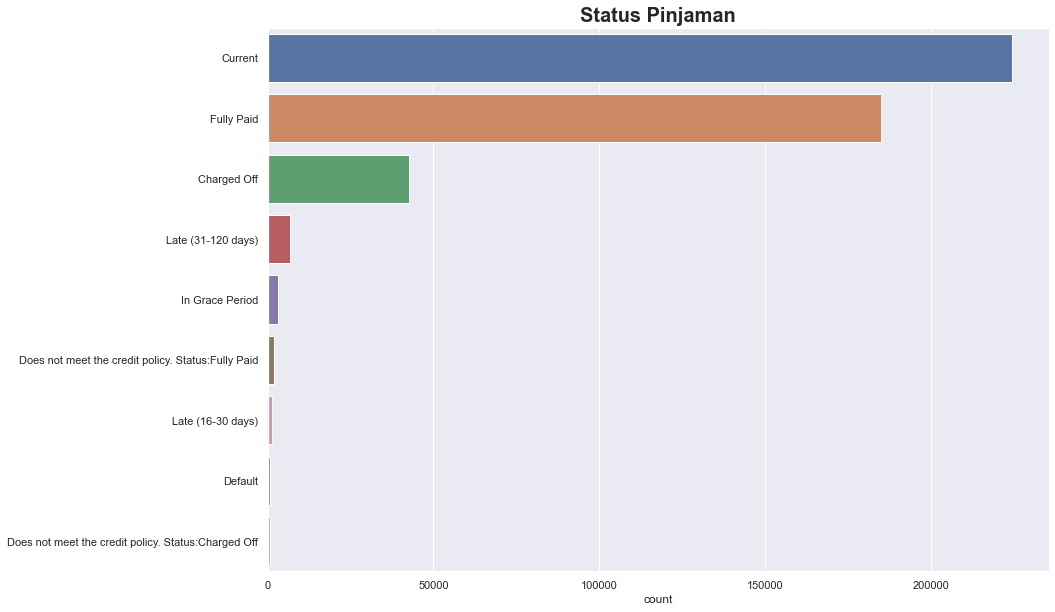

Current                                                48.09%
Fully Paid                                             39.62%
Charged Off                                             9.11%
Late (31-120 days)                                      1.48%
In Grace Period                                         0.67%
Does not meet the credit policy. Status:Fully Paid      0.43%
Late (16-30 days)                                       0.26%
Default                                                 0.18%
Does not meet the credit policy. Status:Charged Off     0.16%
Name: loan_status, dtype: object


In [11]:
plot_count(raw_df, title="Status Pinjaman",  y="loan_status")

## Menentukan Status Pinjaman
Tujuan kita disini adalah menentukan pinjaman mana yang berkemungkinan untuk gagal bayar, sehingga kategori yang bisa kita ambil adalah diantara yang berhasil dan yang gagal. Oleh karena itu kita hanya akan mengambil 2 kategori yaitu:
- Disetujui, terdiri dari: Fully Paid
- Ditolak, terdiri dari: Charged Off, Default, dan Does not meet the credit policy

Kita tidak bisa menggunakan `current` karena pinjaman tersebut masih berlangsung, begitu pula dengan `late` dan `in_grace_period`.

In [12]:
# Tentukan kategori yang akan digunakan
approved_cat = ["Fully Paid"]
dissaproved_cat = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Fully Paid",
    "Does not meet the credit policy. Status:Charged Off"
]

In [13]:
# Ganti dengan label baru
def label_loan_status(value):
    if value in approved_cat:
        return 1
    return 0

label_loan_status("Fully Paid")

1

In [14]:
# Saring dan terapkan fungsi
inter_df = raw_df[raw_df["loan_status"].isin(approved_cat + dissaproved_cat)].copy()
inter_df["loan_status"] = inter_df["loan_status"].apply(label_loan_status)

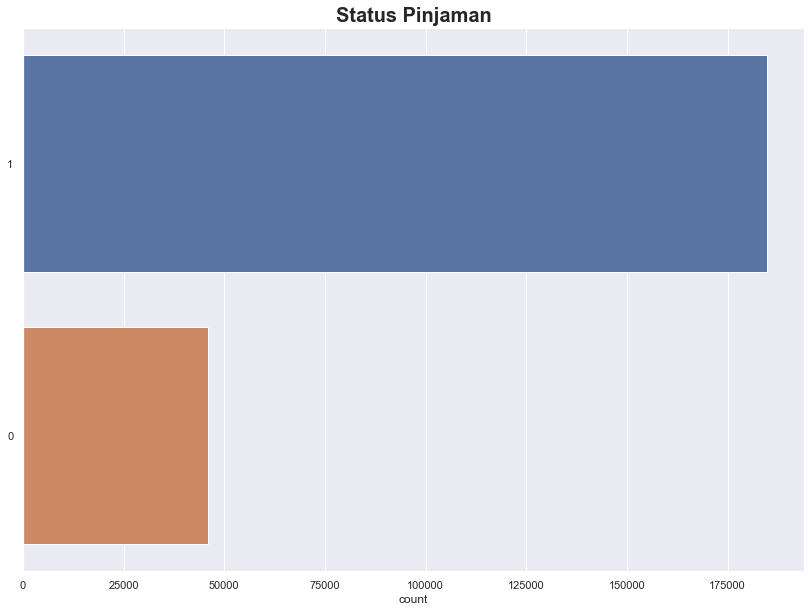

1    80.04%
0    19.96%
Name: loan_status, dtype: object


In [15]:
plot_count(inter_df, y="loan_status", title="Status Pinjaman")

## Korelasi antar Variabel

In [16]:
# Hitung korelasi tiap variabel
correlations = (inter_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=0)
                         .dropna(how="all", axis=1)
)

In [17]:
correlations["loan_status"].abs().sort_values(ascending=False)

loan_status                    1.000000
total_rec_prncp                0.460338
recoveries                     0.445422
last_pymnt_amnt                0.384781
total_pymnt_inv                0.358588
total_pymnt                    0.355349
collection_recovery_fee        0.300094
int_rate                       0.241059
total_rec_late_fee             0.152231
inq_last_6mths                 0.116393
dti                            0.107257
out_prncp                      0.099816
out_prncp_inv                  0.099814
revol_util                     0.089180
tot_cur_bal                    0.076230
mths_since_last_record         0.062190
annual_inc                     0.061623
total_rev_hi_lim               0.052931
loan_amnt                      0.049253
funded_amnt                    0.048790
funded_amnt_inv                0.039854
installment                    0.033419
total_rec_int                  0.032997
total_acc                      0.030680
mths_since_last_delinq         0.029299


In [18]:
# Saring korelasi antara vmin - vmax
vmin, vmax = 0.1, 0.99

unstack_corr = correlations.unstack()
pos_corr = (unstack_corr > vmin) & (unstack_corr < vmax)
neg_corr = (unstack_corr > -vmax) & (unstack_corr < -vmin)
high_corr = unstack_corr[pos_corr | neg_corr]

trimmed_corr = high_corr.sort_values(ascending=False).unstack()

In [19]:
# Buat mask untuk membentuk matriks segitiga bawah
mask = np.zeros_like(trimmed_corr)
mask[np.triu_indices_from(mask)] = True

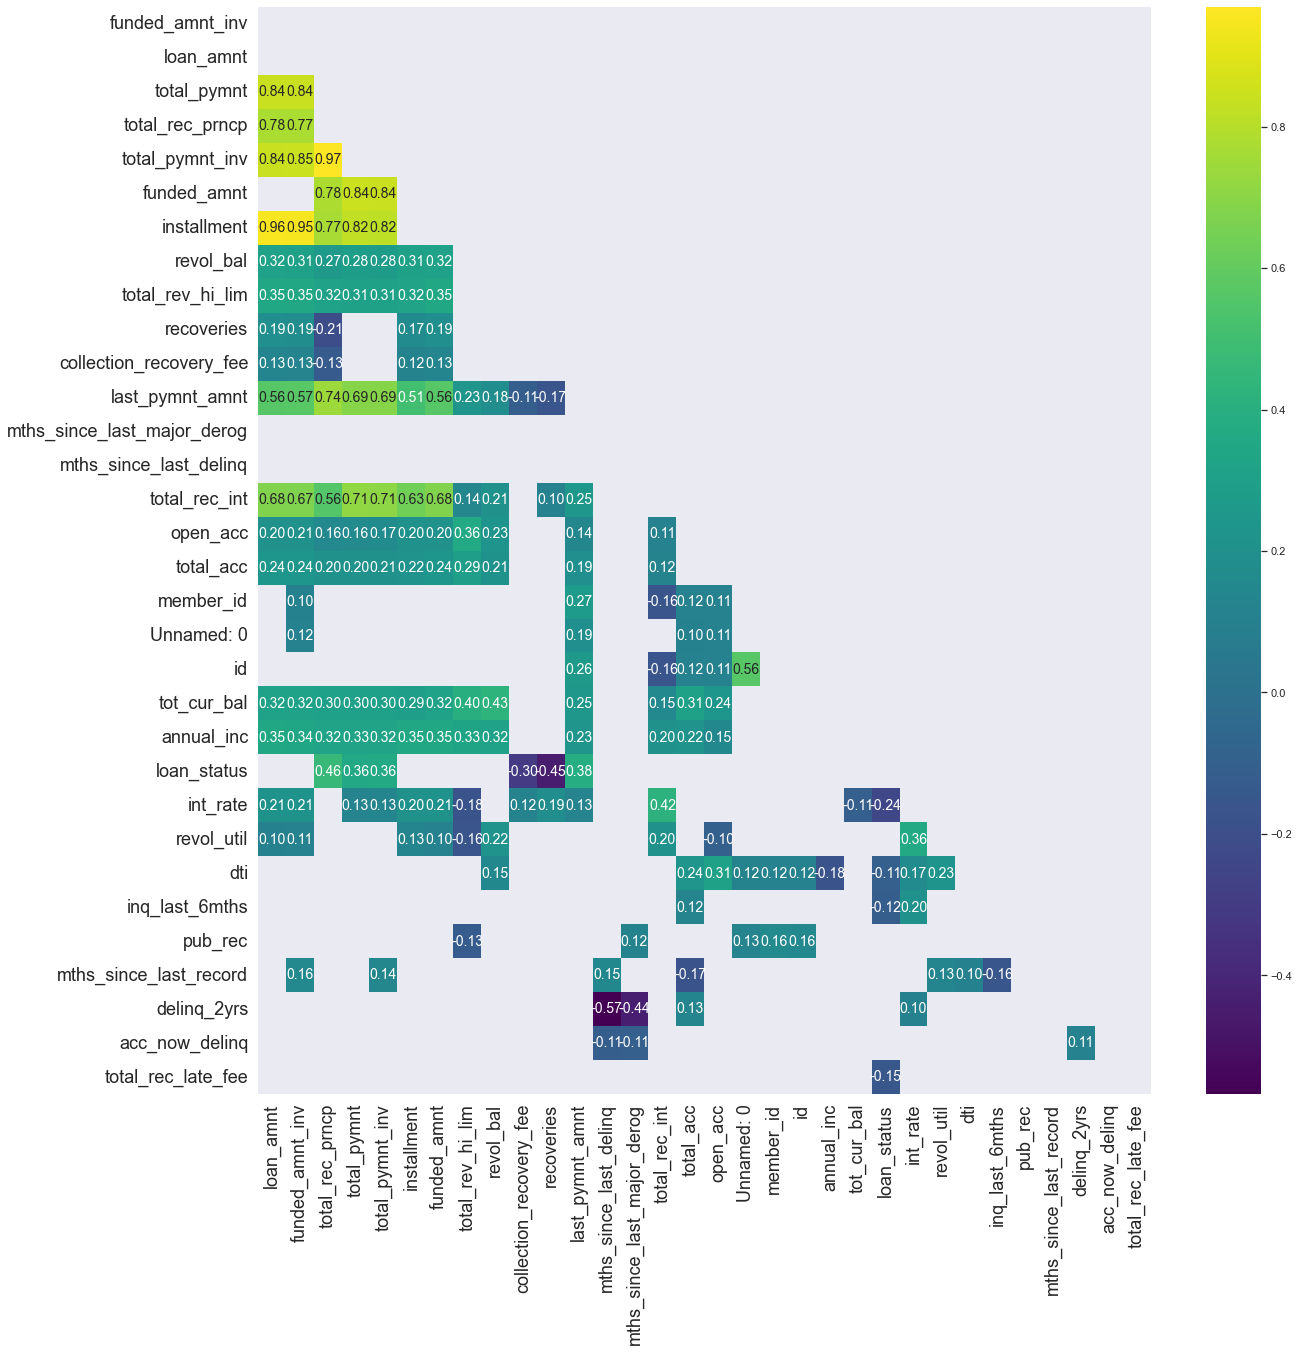

In [20]:
# Tampilkan heatmap
plt.figure(figsize=(20, 20))
plot = sns.heatmap(
    trimmed_corr, 
    annot=True, 
    mask=mask,
    fmt=".2f", 
    cmap="viridis", 
    annot_kws={"size": 14})

plot.set_xticklabels(plot.get_xticklabels(), size=18)
plot.set_yticklabels(plot.get_yticklabels(), size=18)
plt.show()

Dari heatmap diatas terdapat beberapa variabel yang memiliki pengaruh terhadap status pinjaman, diantaranya:

In [21]:
affect_loan = high_corr.loc["loan_status"].abs().sort_values(ascending=False)
affect_loan

total_rec_prncp            0.460338
recoveries                 0.445422
last_pymnt_amnt            0.384781
total_pymnt_inv            0.358588
total_pymnt                0.355349
collection_recovery_fee    0.300094
int_rate                   0.241059
total_rec_late_fee         0.152231
inq_last_6mths             0.116393
dti                        0.107257
dtype: float64

Sedangkan fitur yang saling berkorelasi dengan yang sebelumnya perlu kita identifikasi. Kita menggunakan nilai batas 0.9 untuk mencari fitur yang saling berkorelasi kuat.

In [22]:
threshold = 0.9
affect_collision = (high_corr.abs()
                             .loc[high_corr > threshold]
                             .loc[affect_loan.index, affect_loan.index]
                             .sort_values(ascending=False)
)
affect_collision

total_rec_prncp  total_pymnt        0.975030
total_pymnt      total_rec_prncp    0.975030
total_rec_prncp  total_pymnt_inv    0.969473
total_pymnt_inv  total_rec_prncp    0.969473
dtype: float64

Berdasarkan besar pengaruhnya terhadap status pinjaman, fitur yang saling berkorelasi akan dipilih berdasarkan yang paling berpengaruh.

In [23]:
left_index = affect_collision.index.get_level_values(0)
right_index = affect_collision.index.get_level_values(1)

def remove_collide_index(left_index, right_index):
    include, exclude = [], []

    for left, right in zip(left_index, right_index):
        if left not in include and left not in exclude:
            include.append(left)
        if right not in include and right not in exclude:
            exclude.append(right)
        
    return include, exclude


include_affect_col, exclude_affect_col = remove_collide_index(left_index, right_index)
include_affect_col, exclude_affect_col

(['total_rec_prncp'], ['total_pymnt', 'total_pymnt_inv'])

Fitur numerik berpengaruh yang akan kita gunakan

In [24]:
affect_cols = affect_loan[~affect_loan.index.isin(exclude_affect_col)]
affect_cols

total_rec_prncp            0.460338
recoveries                 0.445422
last_pymnt_amnt            0.384781
collection_recovery_fee    0.300094
int_rate                   0.241059
total_rec_late_fee         0.152231
inq_last_6mths             0.116393
dti                        0.107257
dtype: float64

## Status Pinjaman dan Besar Pinjaman Pokok yang Sudah Dibayarkan
Principal adalah besar pinjaman pokok yang dipinjamkan kepada debitur. Dengan kata lain merupakan jumlah asli dari uang yang dipinjamkan. Orang yang mengalami gagal bayar kebanyakan belum dapat membayarkan uang pokok pembayaran hingga jatuh tempo, bisa dilihat dari distribusi pembayaran dibawah. Rata-ratanya hampir mencapai 0.


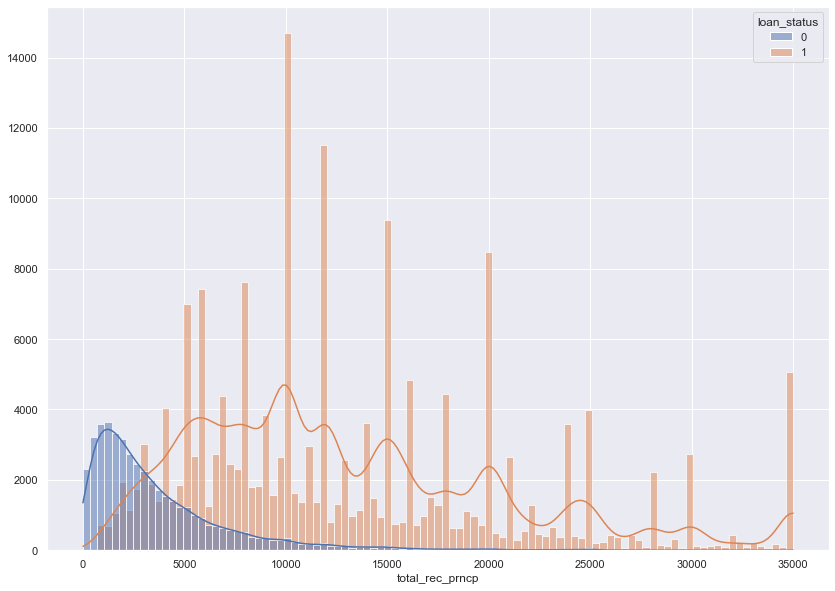

In [25]:
plot_distribution(df=inter_df, x="total_rec_prncp", hue="loan_status", title="")

## Status Pinjaman dan Total Uang yang Tidak Ditagihkan
Charged off recoveries adalah total uang yang tidak bisa dibayarkan kepada perusahaan peminjam karena sudah lewat masa jatuh tempo sehingga perusahaan peminjam bisa melepas hak tagih utang tersebut dengan menjualnya ke perusahaan lain. Dari sini terlihat jelas bahwa orang dengan status pinjaman buruk lah yang paling banyak memiliki charge off recoveries.

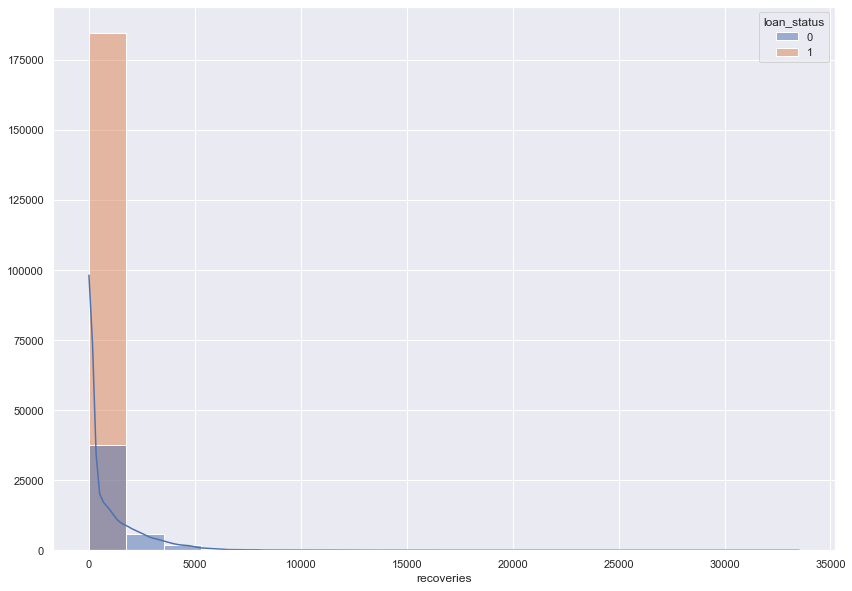

In [26]:
plot_distribution(df=inter_df, x="recoveries", hue="loan_status", title="")

## Status Pinjaman dan Jumlah Pinjaman
Rata-rata jumlah pinjaman terbanyak berada pada status `buruk`.

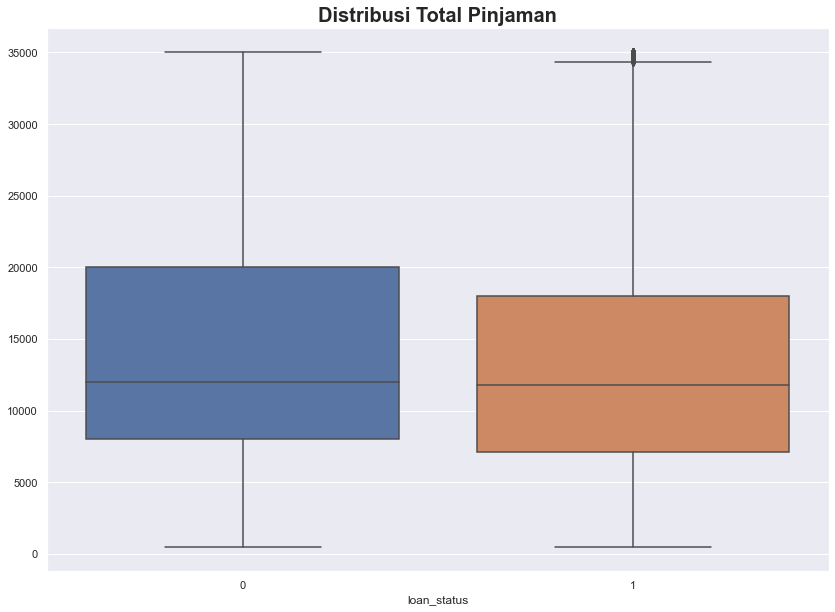

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,14205.570393,8362.468087,500.0,8000.0,12000.0,20000.0,35000.0
1,184739.0,13214.394226,7949.030252,500.0,7125.0,11800.0,18000.0,35000.0


In [ ]:
x, y = "loan_status", "loan_amnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribusi Total Pinjaman")
inter_df.groupby(x)[y].describe()

## Status Pinjaman dan Total Pembayaran yang Diterima
Tampak jelas apabila total pembayaran terbanyak berada pada pinjaman yang berstatus `baik`.

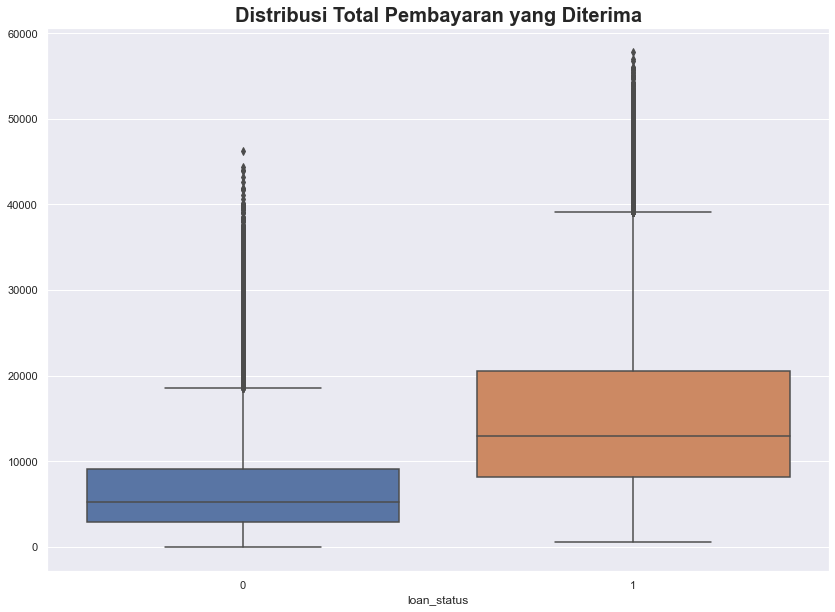

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,6814.461231,5610.294962,0.00,2829.912500,5260.94000,9120.685,46199.44000
1,184739.0,15209.872007,9459.142043,526.33,8092.460697,12979.34106,20491.905,57777.57987


In [ ]:
x, y = "loan_status", "total_pymnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribusi Total Pembayaran yang Diterima")
inter_df.groupby(x)[y].describe()

## Tujuan Mengambil Pinjaman
Lebih dari setengah peminjam memiliki tujuan untuk menutup pinjaman sebelumnya. Apabila dilihat dari jenisnya, tujuan untuk konsumsi lebih banyak daripada tujuan untuk bisnis, renovasi dan pendidikan.

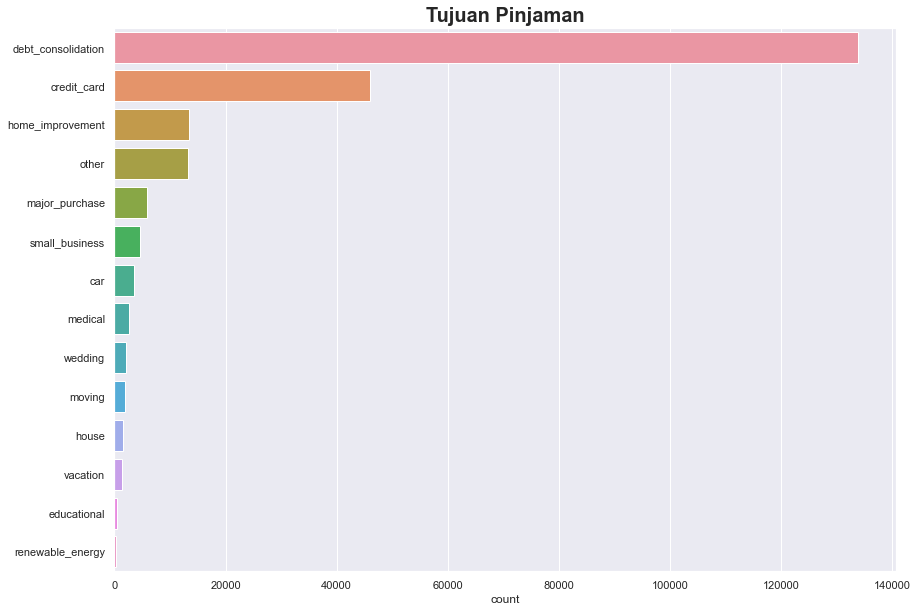

debt_consolidation    58.03%
credit_card           19.95%
home_improvement       5.83%
other                  5.76%
major_purchase         2.54%
small_business         2.02%
car                    1.50%
medical                1.15%
wedding                0.87%
moving                 0.80%
house                  0.65%
vacation               0.62%
educational            0.18%
renewable_energy       0.11%
Name: purpose, dtype: object


In [27]:
plot_count(inter_df, y="purpose", title="Tujuan Pinjaman")

## Negara Asal Peminjam
Peminjam sebagian besar berasal dari negara Kanada.


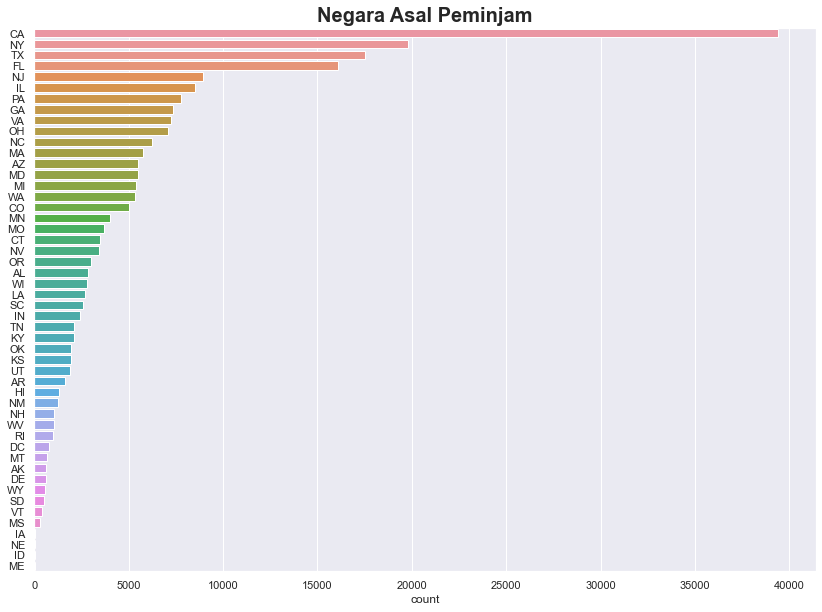

CA    17.08%
NY     8.58%
TX     7.60%
FL     6.96%
NJ     3.87%
IL     3.70%
PA     3.36%
GA     3.17%
VA     3.14%
OH     3.06%
NC     2.69%
MA     2.48%
AZ     2.38%
MD     2.37%
MI     2.33%
WA     2.32%
CO     2.18%
MN     1.73%
MO     1.59%
CT     1.50%
NV     1.49%
OR     1.31%
AL     1.24%
WI     1.21%
LA     1.16%
SC     1.11%
IN     1.04%
TN     0.91%
KY     0.90%
OK     0.84%
KS     0.83%
UT     0.82%
AR     0.70%
HI     0.57%
NM     0.54%
NH     0.46%
WV     0.45%
RI     0.43%
DC     0.34%
MT     0.29%
AK     0.27%
DE     0.26%
WY     0.24%
SD     0.21%
VT     0.17%
MS     0.13%
IA     0.01%
NE     0.01%
ID     0.00%
ME     0.00%
Name: addr_state, dtype: object


In [28]:
plot_count(df=inter_df, y="addr_state", title="Negara Asal Peminjam")

## Tingkat Pinjaman
Pinjaman diberi tingkatan dari huruf abjad A sampai G, semakin mendekati G maka tingkat bunga yang dibayarkan lebih besar.

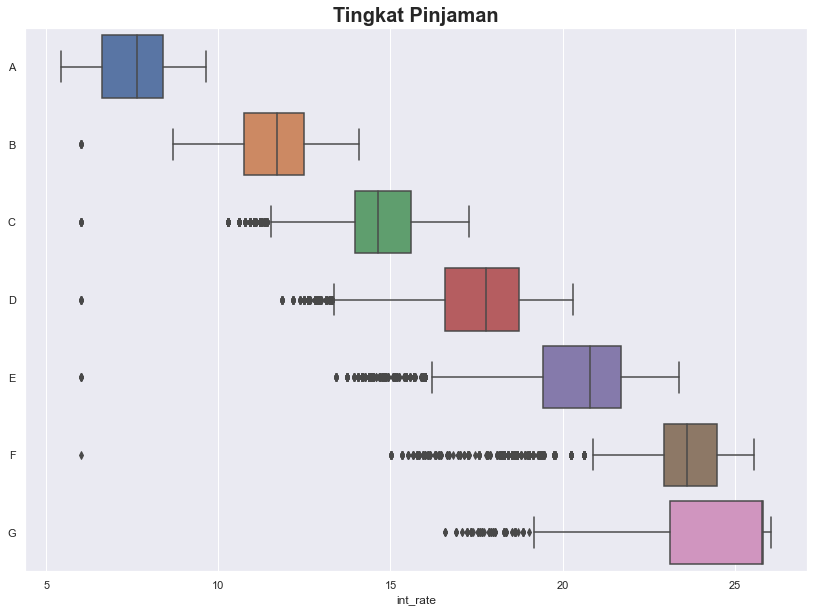

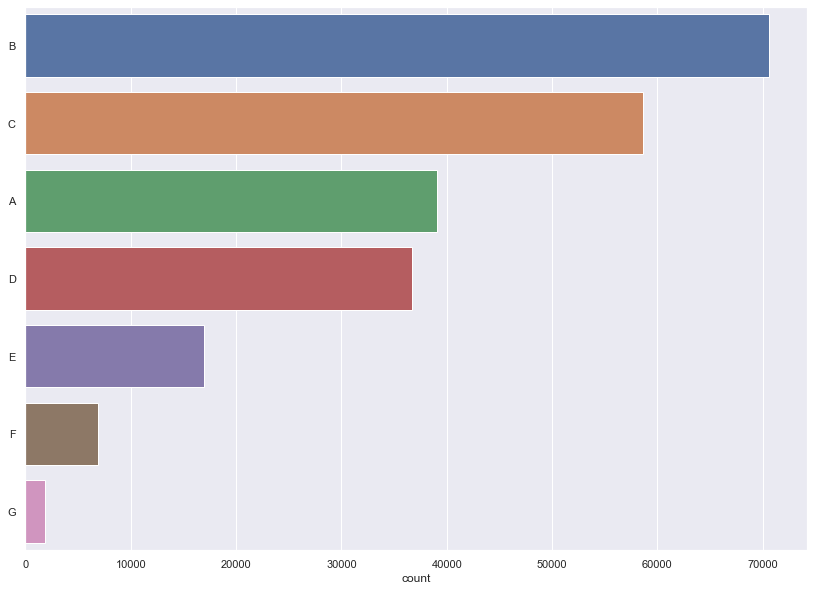

B    30.60%
C    25.40%
A    16.95%
D    15.92%
E     7.34%
F     2.99%
G     0.80%
Name: grade, dtype: object


,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,39110.0,7.545742,1.003571,5.42,6.62,7.62,8.39,9.63
B,70622.0,11.654616,1.281087,6.00,10.74,11.71,12.49,14.09
C,58626.0,14.767515,1.233598,6.00,13.98,14.64,15.61,17.27
D,36740.0,17.628885,1.484771,6.00,16.59,17.77,18.75,20.31
E,16945.0,20.341001,1.920465,6.00,19.42,20.80,21.70,23.40
F,6896.0,23.137195,2.097052,6.00,22.95,23.63,24.50,25.57
G,1856.0,24.191482,2.509841,16.59,23.13,25.80,25.83,26.06


In [ ]:
x, y = "int_rate", "grade"
order = inter_df[y].sort_values().unique()
plot_boxplot(inter_df, x=x, y=y, title="Tingkat Pinjaman", order=order)
plot_count(df=inter_df, y=y, title="")
inter_df.groupby(y)[x].describe()

## Status Kepemilikan Rumah
Sebagian besar peminjam mendelegasikan rumahnya sebagai jaminan pinjaman, sedangkan hanya sedikit dari peminjam yang memiliki rumah sendiri.

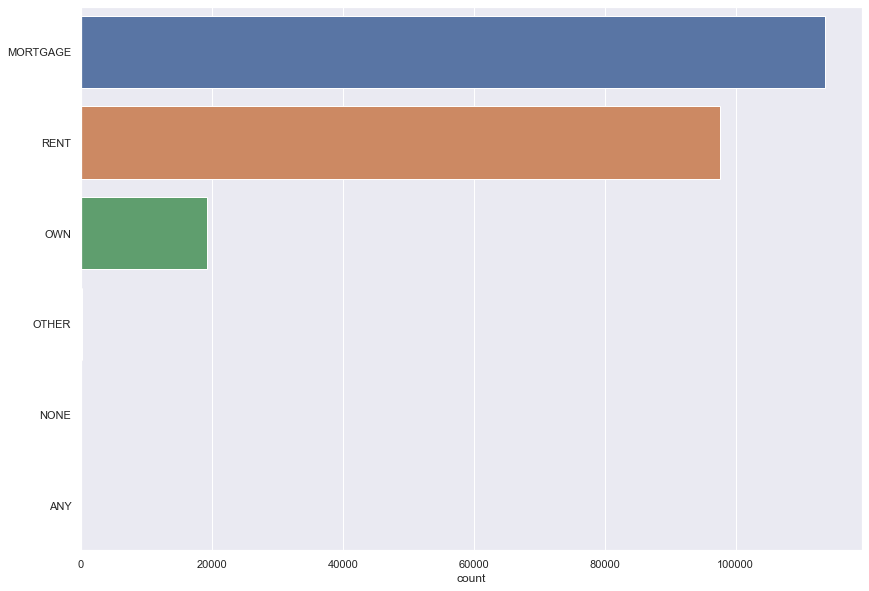

MORTGAGE    49.23%
RENT        42.29%
OWN          8.38%
OTHER        0.08%
NONE         0.02%
ANY          0.00%
Name: home_ownership, dtype: object


In [48]:
y = "home_ownership"
order = inter_df[y].sort_values().unique()
plot_count(df=inter_df, y=y, title="")

# Praproses Data

## Menghilangkan fitur yang tidak terpakai
Setelah melihat info dan deskripsi dari data diatas, terdapat fitur yang tidak perlu kita pakai karena tidak begitu signifikan untuk digunakan sebagai fitur dalam prediksi.

In [49]:
# Informasi rinci mengenai kolom dan baris data
data_stat = pd.DataFrame()
data_stat.index = inter_df.columns
data_stat["unique_value"] = inter_df.nunique()
data_stat["missing_rate"] = inter_df.isna().mean()
data_stat["dtype"] = inter_df.dtypes
data_stat

,unique_value,missing_rate,dtype
Unnamed: 0,230795,0.000000,int64
id,230795,0.000000,int64
member_id,230795,0.000000,int64
loan_amnt,1308,0.000000,int64
funded_amnt,1311,0.000000,int64
funded_amnt_inv,9552,0.000000,float64
term,2,0.000000,object
int_rate,505,0.000000,float64
installment,43071,0.000000,float64
grade,7,0.000000,object


Kolom dengan data yang tidak bisa dipakai

In [50]:
# Kolom yang semua datanya hilang
miss_col = data_stat[data_stat["missing_rate"] == 1].index.to_list()
print("Kolom yang semua datanya hilang:")
print(miss_col)
print()

# Kolom yang terlalu unik
vari_col = data_stat[data_stat["unique_value"] == inter_df.shape[0]].index.to_list()
print("Kolom yang terlalu unik:")
print(vari_col)
print()

# Kolom yang terdiri dari satu nilai
single_valued_col = data_stat[data_stat["unique_value"] == 1].index.to_list()
print("Kolom yang terlalu unik:")
print(single_valued_col)
print()

removed_features = miss_col + vari_col + single_valued_col

Kolom yang semua datanya hilang:
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

Kolom yang terlalu unik:
['Unnamed: 0', 'id', 'member_id', 'url']

Kolom yang terlalu unik:
['policy_code', 'application_type']



In [51]:
# Hilangkan fitur yang tidak terpakai
pre_df = inter_df.loc[:, ~inter_df.columns.isin(removed_features)].copy()
pre_df.shape

(230795, 52)

# Fitur Kategorikal

In [52]:
# Kolom-kolom yang berdata kategorik
pre_df.select_dtypes(include=object).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

### Kolom yang berisikan tanggal

In [53]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

for col in date_cols:
    print(pre_df[col].value_counts().iloc[:5])
    print()

Oct-14    8808
Jul-14    8614
Apr-14    6744
Nov-13    6665
Oct-13    6653
Name: issue_d, dtype: int64

Oct-00    1972
Oct-99    1837
Nov-00    1796
Oct-01    1779
Aug-00    1758
Name: earliest_cr_line, dtype: int64

Jul-15    11703
Mar-15    10087
Jun-15    10078
Apr-15    10051
Aug-15     9932
Name: last_pymnt_d, dtype: int64

Jan-16    93758
Dec-15    13753
Nov-15     8199
Sep-15     7942
Oct-15     7805
Name: last_credit_pull_d, dtype: int64

Feb-16    795
Mar-11    107
Apr-11    101
Feb-11     91
Jan-11     79
Name: next_pymnt_d, dtype: int64



In [204]:
def to_datetime(column):
    return pd.to_datetime(column, format="%b-%y")

### Kolom yang seharusnya numerik
Terdapat kolom bertipe data objek yang juga memiliki nilai numerik di dalamnya. Pada kasus ini, kita cukup mengeluarkan angkanya.

#### emp_length

In [290]:
# Emp_length
emp_counts = inter_df["emp_length"].value_counts()
print(emp_counts)

## Ambil angka pada baris kolom
object_df["emp_length"] = inter_df["emp_length"].str.extract("(< \d+|\d+)")

## Ubah tahun menjadi angka
def year_to_num(value):
    if value is np.nan: 
        return value
    if "<" in value:
        return 0
    return int(value)

## Terapkan fungsi
object_df["emp_length"] = object_df["emp_length"].apply(year_to_num)
object_df["emp_length"]


10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: emp_length, dtype: int64


0         10.0
1          0.0
2         10.0
3         10.0
4          1.0
          ... 
466280     4.0
466281    10.0
466282     7.0
466283     3.0
466284    10.0
Name: emp_length, Length: 466285, dtype: float64

#### sub_grade

In [291]:
# Elemen Sub_grade
inter_df["sub_grade"].str.extract("([A-Z])")[0].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [292]:
# Sub_grade
grade_counts = inter_df["sub_grade"].value_counts()
print(grade_counts[:10])

# Tabel peringkat
grade_map = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}

# Ubah peringkat menjadi angka
def grade_num(sub_grade):
    grade, num = sub_grade
    grade_value = grade_map[grade] + int(num) / 10
    return grade_value

## Terapkan fungsi
object_df["sub_grade"] = inter_df["sub_grade"].apply(grade_num)
object_df["sub_grade"]


B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
Name: sub_grade, dtype: int64


0         2.2
1         3.4
2         3.5
3         3.1
4         2.5
         ... 
466280    3.2
466281    4.5
466282    4.1
466283    1.4
466284    4.3
Name: sub_grade, Length: 466285, dtype: float64

### Kolom yang seharusnya biner
Kolom biner memiliki jumlah kardinalitas sebesar 2. Mengetahui hal tersebut, kita bisa langsung mengganti kategori yang satu dengan angka 0 dan kategori satunya lagi dengan angka 1.

In [293]:
def one_hot_columns(df, colname):
    ohe = OneHotEncoder(drop="first")
    vector = df[colname].to_numpy().reshape(-1, 1)
    vector = ohe.fit_transform(vector).toarray()
    return vector, ohe

#### term

In [294]:
# Term
vector, ohe_term = one_hot_columns(inter_df, "term")

object_df["term"] = vector
object_df["term"].value_counts(), ohe_term.categories_

(0.0    337953
 1.0    128332
 Name: term, dtype: int64,
 [array([' 36 months', ' 60 months'], dtype=object)])

#### initial_list_status

In [295]:
# Initial_list_status
vector, ohe_init_list = one_hot_columns(inter_df, "initial_list_status")

object_df["initial_list_status"] = vector
object_df["initial_list_status"].value_counts(), ohe_init_list.categories_

(0.0    303005
 1.0    163280
 Name: initial_list_status, dtype: int64,
 [array(['f', 'w'], dtype=object)])

#### pyment_plan

In [296]:
# Payment_plan
vector, ohe_pyment = one_hot_columns(inter_df, "pymnt_plan")

object_df["pymnt_plan"] = vector
object_df["pymnt_plan"].value_counts(), ohe_pyment.categories_

(0.0    466276
 1.0         9
 Name: pymnt_plan, dtype: int64,
 [array(['n', 'y'], dtype=object)])

### Kolom yang berlebihan
Dua atau lebih kolom yang memberikan informasi yang mirip memberikan sedikit tingkat pembeda pada tiap barisnya. Oleh karena itu, kita perlu menghilangkan salah satunya.

#### grade dan sub_grade

In [297]:
inter_df[["grade", "sub_grade"]].head()

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5


In [298]:
del object_df["grade"]

#### title dan purpose

In [299]:
inter_df[["title", "purpose"]].head()

,title,purpose
0,Computer,credit_card
1,bike,car
2,real estate business,small_business
3,personel,other
4,Personal,other


In [300]:
del object_df["title"]

### Kolom yang tidak terpakai
Sisanya adalah kolom yang tidak terpakai, banyak alasan yang menyebabkan kolom tersebut tidak dipakai salah satunya adalah tingkat kardinalitas yang tinggi. Pada langkah ini kita akan mencari kolom yang sekiranya tidak memberikan informasi penting atau memberikan informasi yang kurang jelas.

#### zip_code
`zip_code` tidak begitu membantu karena 3 angka dibelakangnya disembunyikan. Kita sudah memiliki kolom yang merepresentasikan tempat yaitu `addr_state`, sehingga `zip_code` akan kita hapus.

In [301]:
inter_df["zip_code"].head()

0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

In [302]:
del object_df["zip_code"]

#### emp_title
`emp_title` memiliki jumlah kardinalitas yang besarnya hampir setengah jumlah data, untuk menghindari resiko tingginya dimensi data, kita akan menghilangkan kolom ini.

In [303]:
inter_df["emp_title"].head()

0                        None
1                       Ryder
2                        None
3         AIR RESOURCES BOARD
4    University Medical Group
Name: emp_title, dtype: object

In [304]:
del object_df["emp_title"]

#### desc
`desc` merupakan kolom tekstual yang sebagian besar isinya sudah dijelaskan pada kolom-kolom yang lain, seperti tanggal peminjaman dan alasan meminjam.

In [305]:
inter_df["desc"].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                 None
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

In [306]:
del object_df["desc"]

## Imputasi Missing Value

In [307]:
object_df.isna().mean().sort_values(ascending=False)

emp_length             0.045054
term                   0.000000
sub_grade              0.000000
home_ownership         0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
pymnt_plan             0.000000
purpose                0.000000
addr_state             0.000000
earliest_cr_line       0.000000
initial_list_status    0.000000
last_pymnt_d           0.000000
next_pymnt_d           0.000000
last_credit_pull_d     0.000000
dtype: float64

<AxesSubplot:ylabel='Frequency'>

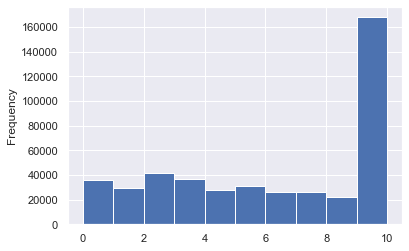

In [308]:
# Lihat distribusi data
object_df["emp_length"].plot(kind="hist")

In [309]:
# Gunakan nilai maksimal untuk kolom emp_length
object_df["emp_length"] = object_df["emp_length"].fillna(object_df["emp_length"].max())

## Sisa Kolom Kategorikal
Kolom-kolom kategorikal yang tersisa akan dibiarkan dan nantinya akan digunakan sebagai prediktor.

In [310]:
cat_df = object_df.select_dtypes(include=object).copy()
cat_df

,home_ownership,verification_status,loan_status,purpose,addr_state
0,RENT,Verified,Fully Paid,credit_card,AZ
1,RENT,Source Verified,Charged Off,car,GA
2,RENT,Not Verified,Fully Paid,small_business,IL
3,RENT,Source Verified,Fully Paid,other,CA
4,RENT,Source Verified,Current,other,OR
...,...,...,...,...,...
466280,MORTGAGE,Source Verified,Current,debt_consolidation,TX
466281,MORTGAGE,Verified,Charged Off,debt_consolidation,TN
466282,MORTGAGE,Verified,Current,debt_consolidation,OH
466283,OWN,Verified,Fully Paid,credit_card,CA


In [311]:
cat_df.nunique()

home_ownership          6
verification_status     3
loan_status             9
purpose                14
addr_state             50
dtype: int64

## Kolom Numerikal

In [312]:
num_df = inter_df.select_dtypes(include=["int", "float"]).copy()
num_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,NaN,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,NaN,0.0,NaN,NaN,NaN


### Imputasi Missing Value

In [313]:
def get_missing_rate(df):
    miss_rate = df.isna().mean()
    miss_filter = miss_rate > 0
    miss_rate = miss_rate[miss_filter].sort_values(ascending=False)
    return miss_rate

miss_rate = get_missing_rate(num_df)
miss_rate

mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
mths_since_last_delinq         0.536906
tot_coll_amt                   0.150715
tot_cur_bal                    0.150715
total_rev_hi_lim               0.150715
revol_util                     0.000729
collections_12_mths_ex_med     0.000311
delinq_2yrs                    0.000062
inq_last_6mths                 0.000062
open_acc                       0.000062
pub_rec                        0.000062
total_acc                      0.000062
acc_now_delinq                 0.000062
annual_inc                     0.000009
dtype: float64

#### Melihat Distribusi Data

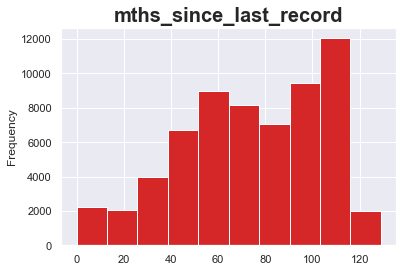

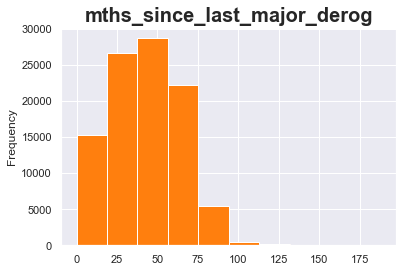

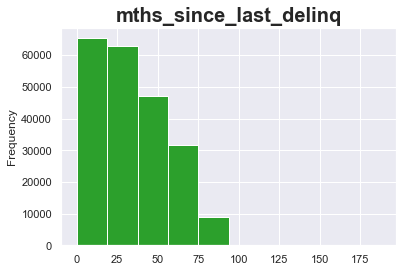

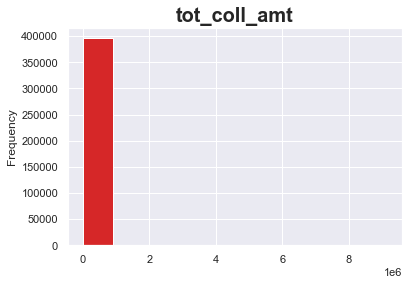

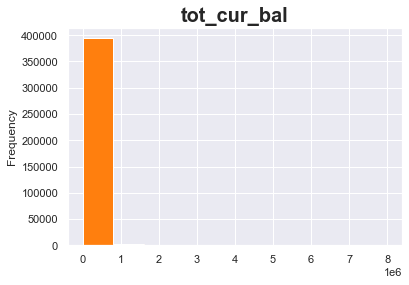

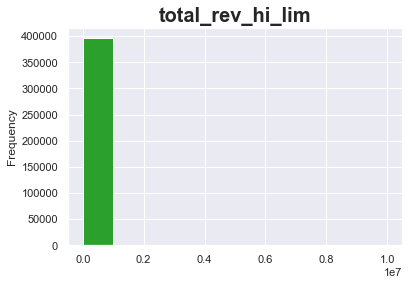

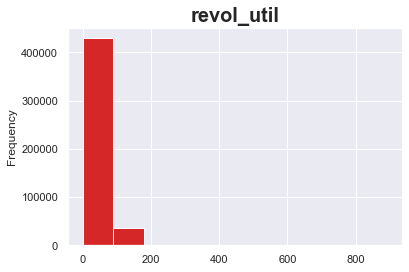

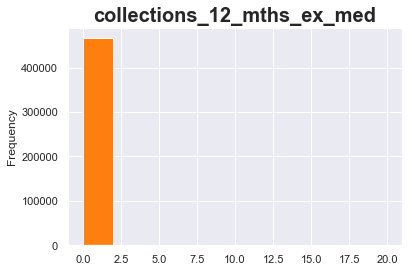

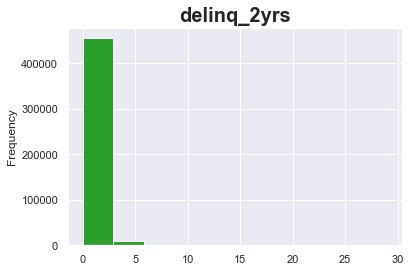

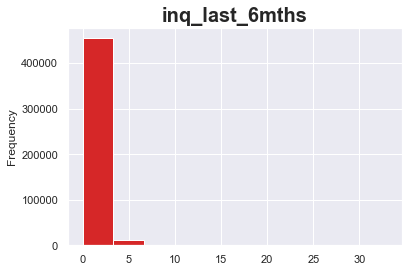

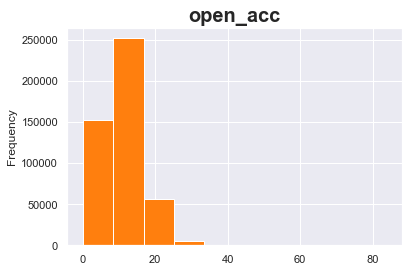

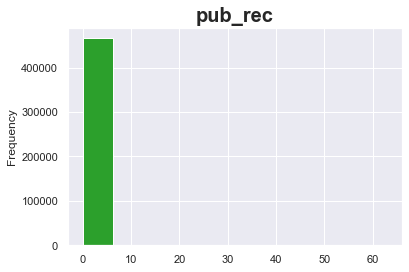

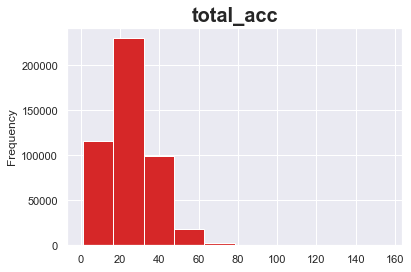

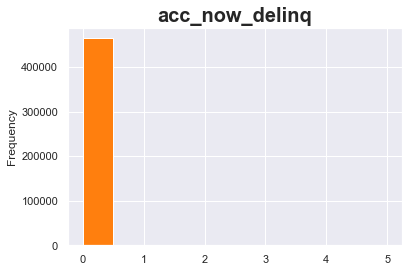

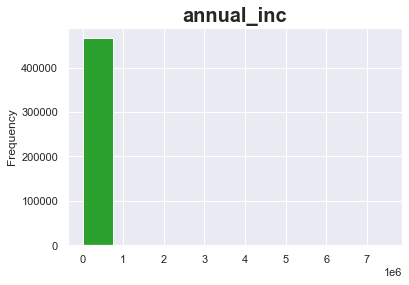

In [314]:
colormap = ["tab:red", "tab:orange", "tab:green"]
colorgen = itertools.cycle(colormap)

for colname, color in zip(miss_rate.index, colorgen):
    plt.figure()
    plt.title(colname, fontdict=title_font)
    num_df[colname].plot(kind="hist", color=color)

#### Imputasi berdasarkan distribusi

In [315]:
miss_rate.index

Index(['mths_since_last_record', 'mths_since_last_major_derog',
       'mths_since_last_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'revol_util', 'collections_12_mths_ex_med',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'annual_inc'],
      dtype='object')

In [316]:
col_items = [
    ("mths_since_last_record", "median"),
    ("mths_since_last_major_derog", "mean"),
    ("mths_since_last_delinq", "mean"),
    ("tot_coll_amt", "most_frequent"),
    ("tot_cur_bal", "most_frequent"),
    ("total_rev_hi_lim", "most_frequent"),
    ("revol_util", "most_frequent"),
    ("collections_12_mths_ex_med", "most_frequent"),
    ("delinq_2yrs", "most_frequent"),
    ("inq_last_6mths", "most_frequent"),
    ("open_acc", "mean"),
    ("pub_rec", "most_frequent"),
    ("total_acc", "mean"),
    ("acc_now_delinq", "most_frequent"),
    ("annual_inc", "most_frequent"),
]

In [317]:
for col, method in col_items:
    array = num_df[col].to_numpy().reshape(-1, 1)
    filled_array = SimpleImputer(strategy=method).fit_transform(array)
    num_df[col] = filled_array
    print(f"Filled {col} with {method} value")

Filled mths_since_last_record with median value
Filled mths_since_last_major_derog with mean value
Filled mths_since_last_delinq with mean value
Filled tot_coll_amt with most_frequent value
Filled tot_cur_bal with most_frequent value
Filled total_rev_hi_lim with most_frequent value
Filled revol_util with most_frequent value
Filled collections_12_mths_ex_med with most_frequent value
Filled delinq_2yrs with most_frequent value
Filled inq_last_6mths with most_frequent value
Filled open_acc with mean value
Filled pub_rec with most_frequent value
Filled total_acc with mean value
Filled acc_now_delinq with most_frequent value
Filled annual_inc with most_frequent value


In [318]:
num_df.isna().mean()

loan_amnt                      0.0
funded_amnt                    0.0
funded_amnt_inv                0.0
int_rate                       0.0
installment                    0.0
annual_inc                     0.0
dti                            0.0
delinq_2yrs                    0.0
inq_last_6mths                 0.0
mths_since_last_delinq         0.0
mths_since_last_record         0.0
open_acc                       0.0
pub_rec                        0.0
revol_bal                      0.0
revol_util                     0.0
total_acc                      0.0
out_prncp                      0.0
out_prncp_inv                  0.0
total_pymnt                    0.0
total_pymnt_inv                0.0
total_rec_prncp                0.0
total_rec_int                  0.0
total_rec_late_fee             0.0
recoveries                     0.0
collection_recovery_fee        0.0
last_pymnt_amnt                0.0
collections_12_mths_ex_med     0.0
mths_since_last_major_derog    0.0
acc_now_delinq      

## Perbarui Data

In [347]:
pre_df = pd.concat([object_df, num_df], axis=1)

In [348]:
pre_df.head()

,term,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0.0,2.2,10.0,RENT,Verified,12.11,Fully Paid,0.0,credit_card,AZ,1.85,0.0,1.15,0.00,1.16,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,34.10443,76.0,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,42.852547,0.0,0.0,0.0,15000.0
1,1.0,3.4,0.0,RENT,Source Verified,12.11,Charged Off,0.0,car,GA,4.99,0.0,4.13,0.00,9.13,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,34.10443,76.0,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,42.852547,0.0,0.0,0.0,15000.0
2,0.0,3.5,10.0,RENT,Not Verified,12.11,Fully Paid,0.0,small_business,IL,11.01,0.0,6.14,0.00,1.16,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,34.10443,76.0,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,42.852547,0.0,0.0,0.0,15000.0
3,0.0,3.1,10.0,RENT,Source Verified,12.11,Fully Paid,0.0,other,CA,2.96,0.0,1.15,0.00,1.15,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.00000,76.0,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,42.852547,0.0,0.0,0.0,15000.0
4,1.0,2.5,1.0,RENT,Source Verified,12.11,Current,0.0,other,OR,1.96,0.0,1.16,2.16,1.16,3000,3000,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.00000,76.0,15.0,0.0,27783,53.9,38.0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,42.852547,0.0,0.0,0.0,15000.0


# Pemodelan

## Tentukan Label dan Fitur Data
Label merupakan tingkat performa dari pinjaman yang berada pada kolom `loan_status`. Berhubung kolom tersebut memiliki beberapa kategori, kita akan menggabungkannya menjadi 2 kategori yaitu `baik` dan `buruk`.

In [349]:
pre_df["loan_status"].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [352]:
good_loan = ["Current", "Fully Paid"]

def encode_loan_status(value):
    if value in good_loan:
        return 1
    return 0

pre_df["loan_status"] = pre_df["loan_status"].apply(encode_loan_status)
pre_df["loan_status"]

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: loan_status, Length: 466285, dtype: int64

Rasio antara status pinjaman yang `baik` dan `buruk` tidak seimbang, yaitu persentase status pinjaman `baik` lebih besar dari persentase status pinjaman `buruk`.

In [353]:
label_counts = pre_df["loan_status"].value_counts()
label_counts

1    408965
0     57320
Name: loan_status, dtype: int64

In [354]:
label_counts / label_counts.sum()

1    0.877071
0    0.122929
Name: loan_status, dtype: float64

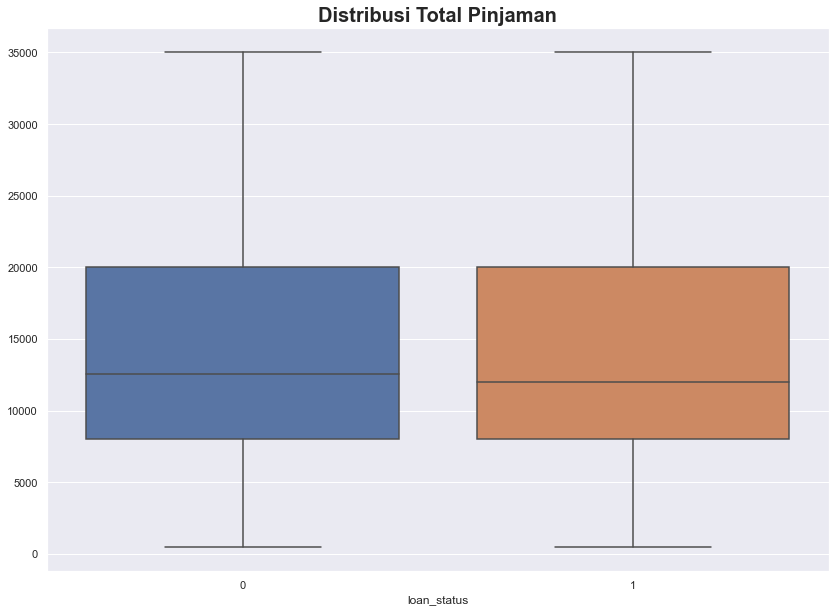

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,57320.0,14507.285851,8407.808377,500.0,8000.0,12550.0,20000.0,35000.0
1,408965.0,14290.646266,8269.027419,500.0,8000.0,12000.0,20000.0,35000.0


In [355]:
x, y = "loan_status", "loan_amnt"
plot_boxplot(df=pre_df, x=x, y=y, title="Distribusi Total Pinjaman")
pre_df.groupby(x)[y].describe()

Sebelumnya, kita perlu memisahkan label dan fitur dari data untuk kemudian dapat dilakukan pemisahan data.

In [356]:
label = pre_df["loan_status"].copy()
features = pre_df.drop(columns=["loan_status"])

print("Label shape:")
print(label.shape)

print("Features shape:")
print(features.shape)

Label shape:
(466285,)
Features shape:
(466285, 46)


## Alur Pelatihan

### Downsample
Kategori status pinjaman `baik` memiliki rasio yang lebih besar ketimbang kategori `buruk`, untuk menghindari bias dalam klasifikasi, data perlu diseimbangkan kembali yaitu dengan cara menurunkan angka sampel pada kategori `baik`.

In [376]:
# Tentukan jumlah sampel dari kategori yang dominan
sample_size = 200000

# Pisahkan kedua kategori lalu sampel ulang satu kategori dominan
neg_label = label[label == 0]
pos_label = label[label == 1].sample(sample_size)

# Gabungkan kedua kategori kembali dan sesuaikan pada fiturnya
label_downsampled = pd.concat([neg_label, pos_label])
features_downsampled = features.loc[label_downsampled.index]

In [377]:
label_downsampled.value_counts()

1    200000
0     57320
Name: loan_status, dtype: int64

### Praproses

In [378]:
numeric_transformer = StandardScaler()
categoric_transformer = OneHotEncoder(drop="first")

cat_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categoric_transformer, selector(dtype_include="object")),
    ]
)

In [379]:
features_encoded = cat_preprocessor.fit_transform(features_downsampled)

In [380]:
features_encoded.shape

(257320, 69)

### Memisahkan Data

In [381]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, label_downsampled, test_size=0.2, random_state=42, stratify=label_downsampled)

In [382]:
X_train.shape, X_test.shape

((205856, 69), (51464, 69))

### Model

In [383]:
logres = LogisticRegression(max_iter=5000, n_jobs=-1)

In [384]:
logres.fit(X_train, y_train)

LogisticRegression(max_iter=5000, n_jobs=-1)

## Menyimpan Model

In [385]:
joblib.dump(logres, "logres.z")

['logres.z']

In [386]:
logres = joblib.load("logres.z")

# Evaluasi Model

## Baseline Model
Kita akan membuat model prediksi paling sederhana yaitu dengan memprediksi seluruh data kategori terbanyak. Hal ini dilakukan supaya kita mendapatkan patokan, berapa performa minimal yang harus dilalui oleh model machine learning kita nantinya. 

In [387]:
test_label_counts = y_test.value_counts()
test_label_counts

1    40000
0    11464
Name: loan_status, dtype: int64

In [388]:
test_label_counts.max() / test_label_counts.sum()

0.77724234416291

## Metrik Klasifikasi

## Train

In [389]:
logres.score(X_train, y_train)

0.7773054951033732

In [390]:
report = classification_report(y_true=y_train, y_pred=logres.predict(X_train))
print(report)

              precision    recall  f1-score   support

           0       0.52      0.00      0.01     45856
           1       0.78      1.00      0.87    160000

    accuracy                           0.78    205856
   macro avg       0.65      0.50      0.44    205856
weighted avg       0.72      0.78      0.68    205856



## Test

In [391]:
logres.score(X_test, y_test)

0.7774560858075548

In [392]:
report = classification_report(y_true=y_test, y_pred=logres.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.57      0.00      0.01     11464
           1       0.78      1.00      0.87     40000

    accuracy                           0.78     51464
   macro avg       0.67      0.50      0.44     51464
weighted avg       0.73      0.78      0.68     51464



## Confusion Matrix

In [394]:
conf = confusion_matrix(y_true=y_test, y_pred=logres.predict(X_test))

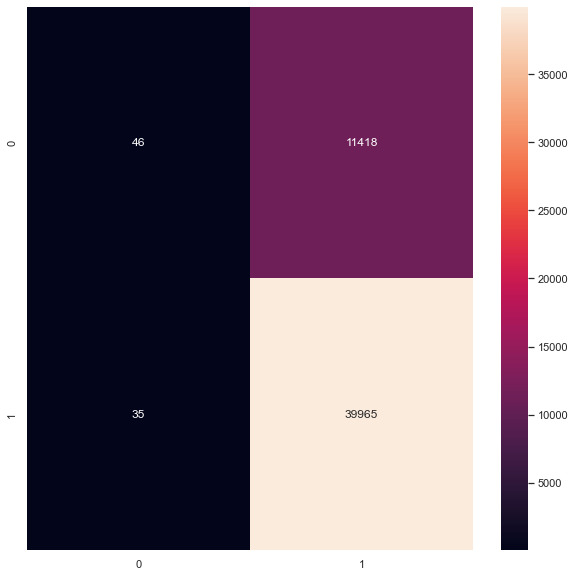

In [399]:
plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="g")
plt.show()